In [21]:
import os
import argparse
import math
import time
import ast
from copy import copy
from glob import glob

import pandas as pd
import numpy as np

import pyproj
from pyproj import Proj
import cv2
import shapely
from shapely.geometry import Point
from shapely.ops import transform
import rioxarray
import geopandas as gpd

import concurrent
import concurrent.futures
from concurrent.futures.thread import ThreadPoolExecutor

import ultralytics
from ultralytics import YOLO

In [ ]:
ast_object_detection/bash/error/predict/predict_100.err

In [45]:
error_paths = glob("/hpc/home/csr33/ast_object_detection/bash/error/predict/*")
nums = [os.path.splitext(os.path.basename(error_path))[0].split("_")[1] for error_path in error_paths]

In [48]:
# Get list of text files
error_nums =[]
# Open file to save output
with open("combined.txt", "w") as outfile:

    # Loop through list of files
    for (error_path, num) in zip(error_paths, nums):
        with open(error_path) as infile:
            # Read contents of each file 
            content = infile.read()
            if len(content) > 0:
                error_nums.append(int(num))
                #print(content)
            # Append to output file
            outfile.write(content)

In [50]:
print(error_nums)

[723, 715, 850, 816, 681, 639, 704, 806, 672, 750, 857, 697, 745, 845, 686, 710, 663, 811, 693, 798, 732, 739]


In [38]:
merged_predictions = glob("/hpc/group/borsuklab/csr33/object_detection/predictions/merged_predictions_*")
nums = [int(os.path.splitext(os.path.basename(merged_prediction))[0].split("_")[2]) for merged_prediction in merged_predictions]
sorted(set(range(1000)) - set(nums) )

[639,
 663,
 672,
 681,
 686,
 693,
 697,
 704,
 710,
 715,
 723,
 732,
 739,
 745,
 750,
 798,
 806,
 811,
 816,
 845,
 850,
 857]

In [2]:
model_path="/work/csr33/object_detection/runs/detect/train_w_tuned_hyperparameters3/weights/best.pt"


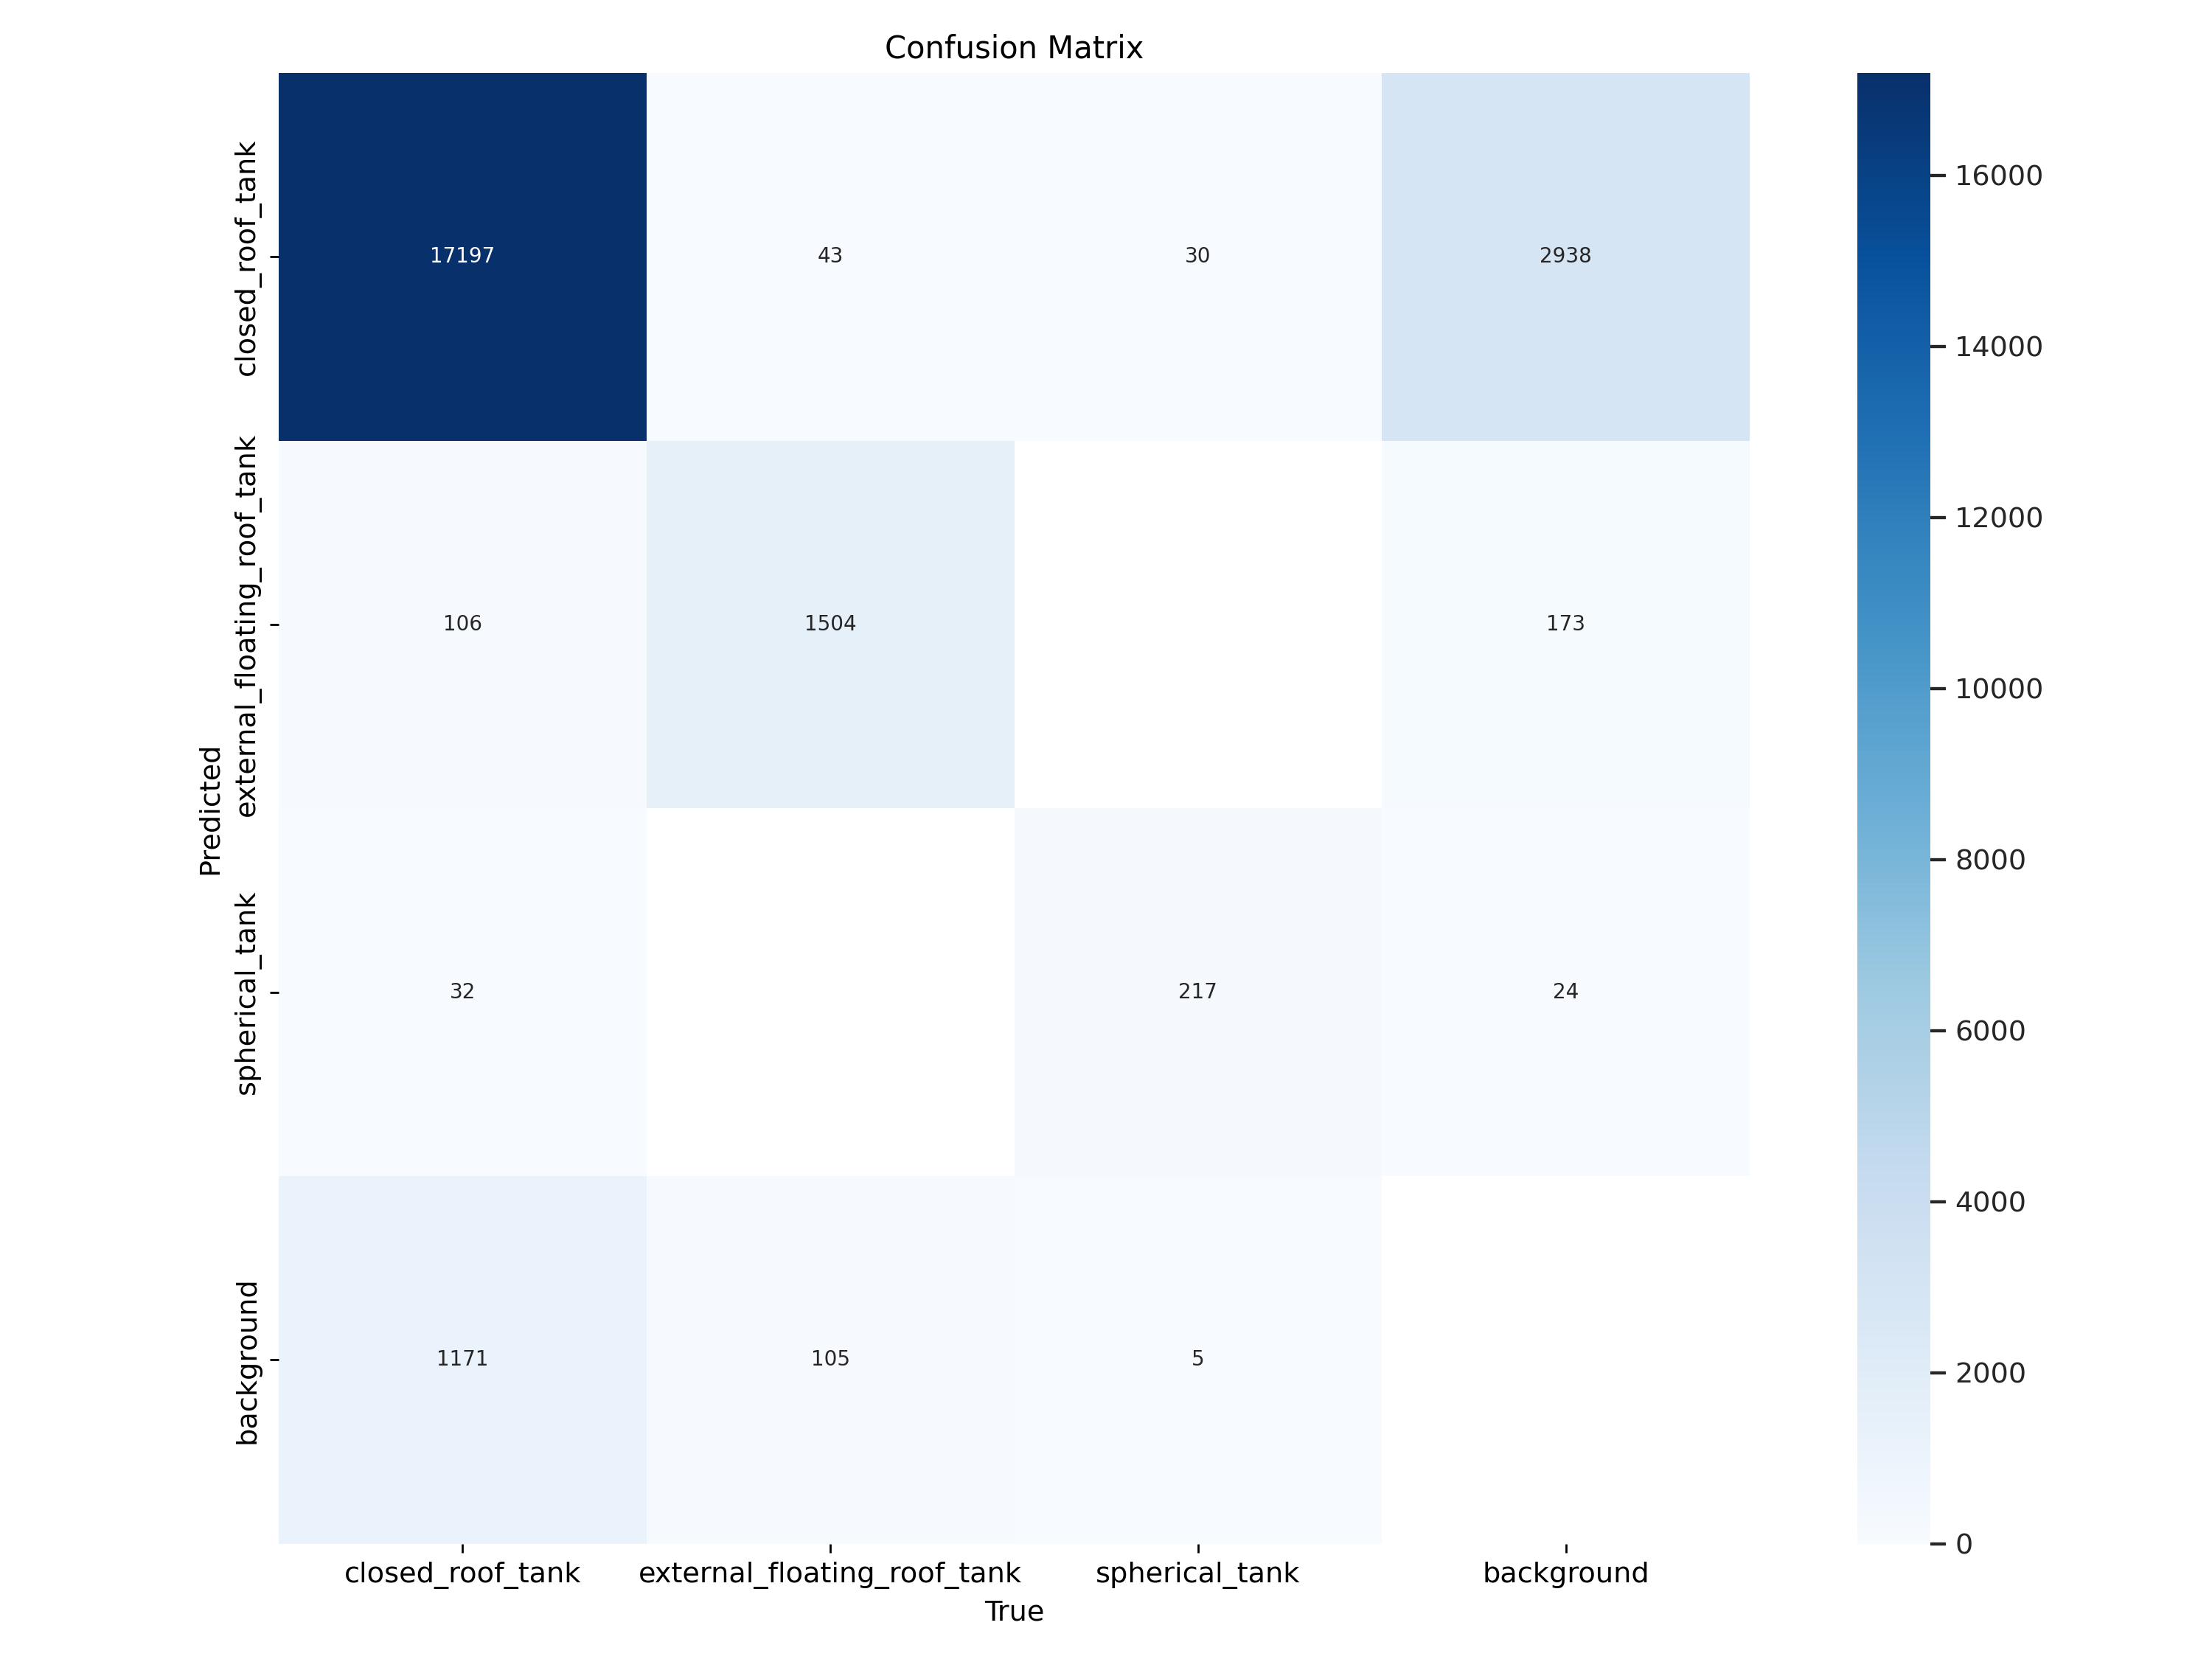

In [29]:
from IPython.display import Image
Image("/work/csr33/object_detection/runs/detect/val/confusion_matrix.png")

In [2]:
predict_error = "/hpc/home/csr33/ast_object_detection/bash/error/predict"
error_paths = [os.path.join(predict_error, f"predict_{i}.err") for i in range(277)]

In [13]:

def read_raster(item_collection):
    #extract raster data
    raster_paths = [i.assets["data"].href for i in item_collection]
    rasters = [rasterio.open(raster_path) for raster_path in raster_paths]
    assert [raster.nodata == -9999 for raster in rasters]
    return rasters


def ensure_raster_tank_intersect(rasters, tank_geometry):
    raster_geoms = [shapely.box(raster.bounds.left,raster.bounds.bottom, raster.bounds.right, raster.bounds.top) for raster in rasters]
    raster_intersects = [tank_geometry.intersects(raster_geom) for raster_geom in raster_geoms]
    return np.array(rasters)[np.array(raster_intersects)]


def calculate_height(rasters, tank_geometry):
    # tank_geometry : geomtry of tank in utm
    #calculate the height for each raster
    h = []
    w = []
    for raster in rasters:
        clipped_image, clipped_transform = rasterio.mask.mask(raster, [tank_geometry], crop=True)
        #clipped_image.shape
        arr = np.array(clipped_image[clipped_image != -9999])
        if len(arr) > 0:
            h.append(np.quantile(arr.flatten(), 0.9))
            w.append(arr.size)
    [raster.close() for raster in rasters] #close rasters
    # average height
    if len(h) > 0:
        return np.average(h, weights=w)
    else:
        return None

def height_estimation_by_tank(row, catalog, args):
    #create utm geometry
    tank_geometry = shapely.geometry.box(*row["utm_coords"], ccw=True) #utm
    #search catalog using lat lon geometry
    item_collection = catalog.search(collections=[args.collection], 
                            intersects=row.geometry.buffer(0.001)).item_collection()

    if len(item_collection) > 0:
        rasters = read_raster(item_collection)
        # ensure tank the data intersects
        rasters = ensure_raster_tank_intersect(rasters, tank_geometry)
        # calculate height
        height = calculate_height(rasters, tank_geometry)
        return height
    else:
        return None
    

def height_estimation_handle_errors(row, catalog, attempt, args):
    
    try:
        height = height_estimation_by_tank(row, catalog, args)
        return height
    except Exception as err:
        print(type(err))    # the exception type
        time.sleep(args.backoff_factor * (2 ** attempt))
        
        
def height_estimation_retry(row, catalog, args): 
    print(args)
    for attempt in range(args.max_retries):
        try:
            height = height_estimation_handle_errors(row, catalog, attempt, args)
            return height
            print(attempt)
            break
        except:
            if attempt == args.max_retries - 1:
                print(f"Failed after {args.max_retries} attempts!")
            else: 
                wait_time = 2 ** attempt # Exponential backoff
                print(f"Failed, retrying in {wait_time} seconds...")
                time.sleep(wait_time)

                
def height_estimation(detected_tanks, args):
    start = time.time()
    height_list = [None] * len(detected_tanks) #height list
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",
                                        modifier = planetary_computer.sign_inplace,)
    
    for i, (tank_id, row) in enumerate(detected_tanks.iterrows()):
        #create utm geometry
        height_list[i] = height_estimation_retry(row, catalog, args)
   
    print(time.time() - start)
    return height_list

In [4]:
def get_args_parse():
    parser = argparse.ArgumentParser("Predict on images")    
    parser.add_argument("--chunk_id",  type=int)
    parser.add_argument("--tile_dir", default="/work/csr33/images_for_predictions/naip_tiles", type=str)
    parser.add_argument("--tilename_chunks_path", default='/hpc/home/csr33/ast_object_detection/images_for_prediction/tilename_chunks.npz', type=str)
    parser.add_argument("--model_path", default="/work/csr33/object_detection/runs/detect/baseline_train/weights/best.pt", type=str)
    parser.add_argument("--prediction_dir", default="/work/csr33/images_for_predictions/predictions", type=str)
    parser.add_argument("--imgsz", default=640, type=int)
    parser.add_argument('--img_dir', type=str, default="/work/csr33/images_for_predictions/naip_imgs")
    parser.add_argument('--classification_threshold', type=float, default=0.5)
    parser.add_argument("--backoff_factor", default=10, type=float)
    parser.add_argument("--max_retries", default=10, type=int)
    args = parser.parse_args()
    return args

In [11]:
import sys
sys.argv = ['my_notebook']
args = get_args_parse()


In [12]:
detected_tanks = gpd.read_parquet(os.path.join(args.prediction_dir, 
                                  f"merged_predictions_{args.chunk_id}.parquet"))[:1]
detected_tanks['utm_coords'] = detected_tanks['utm_coords'].apply(lambda x: ast.literal_eval(x))

In [10]:
#reformat     
detected_tanks["height"] = height_estimation(detected_tanks, args)
detected_tanks['utm_coords'] = detected_tanks['utm_coords'].apply(lambda x: str(x))

detected_tanks.to_parquet(os.path.join(args.prediction_dir, 
                                       f"merged_predictions_height_{args.chunk_id}.parquet"))

In [16]:

x = gpd.read_parquet(os.path.join(args.prediction_dir, 
                                       f"merged_predictions_height_{1}.parquet"))

In [17]:
x

,confidence,class_name,bbox_pixel_coords,tile_names,utm_coords,diameter,utm_proj,geometry,height
0,0.7409072518348694,closed_roof_tank,"[17737, 18176, 17750, 18191]",m_2908955_sw_16_030_20211130,"[286205.25, 3225601.0500000003, 286209.15, 322...",3.9,EPSG:26916,"POLYGON ((-89.19768 29.14097, -89.19768 29.140...",NaN
1,0.815156877040863,closed_roof_tank,"[17966, 18028, 17993, 18058]",m_2908955_sw_16_030_20211130,"[286273.95, 3225645.45, 286282.05000000005, 32...",8.1,EPSG:26916,"POLYGON ((-89.19694 29.14138, -89.19694 29.141...",NaN
2,0.7907156944274902,closed_roof_tank,"[17985, 18048, 18010, 18078]",m_2908955_sw_16_030_20211130,"[286279.65, 3225639.45, 286287.15, 3225630.45]",7.5,EPSG:26916,"POLYGON ((-89.19688 29.14132, -89.19688 29.141...",NaN
3,0.5785607099533081,closed_roof_tank,"[18005, 18066, 18018, 18081]",m_2908955_sw_16_030_20211130,"[286285.65, 3225634.0500000003, 286289.5500000...",3.9,EPSG:26916,"POLYGON ((-89.19686 29.14128, -89.19686 29.141...",NaN
4,0.73138028383255,closed_roof_tank,"[6064, 2205, 6084, 2222]",m_3008935_se_16_030_20211115,"[243349.35, 3369874.35, 243355.35, 3369869.25]",5.1,EPSG:26916,"POLYGON ((-89.67219 30.43367, -89.67219 30.433...",NaN
...,...,...,...,...,...,...,...,...,...
187,0.5011230707168579,closed_roof_tank,"[4551, 5386, 4559, 5394]",m_2608040_sw_17_060_20191120_20200113,"[589770.9, 2921444.1, 589775.7000000001, 29214...",4.8,EPSG:26917,"POLYGON ((-80.09981 26.41036, -80.09981 26.410...",NaN
188,0.6718647480010986,closed_roof_tank,"[855, 63, 871, 77]",m_3108001_nw_17_060_20211202,"[500313.3, 3540597.9000000004, 500322.89999999...",8.4,EPSG:26917,"POLYGON ((-80.99658 32.00146, -80.99658 32.001...",NaN
189,0.6204636096954346,closed_roof_tank,"[2820, 1253, 2829, 1262]",m_4506845_se_19_060_20210929,"[545523.3, 5017458.9, 545528.7000000001, 50174...",5.4,EPSG:26919,"POLYGON ((-68.41920 45.30916, -68.41920 45.309...",0.0
190,0.581403911113739,closed_roof_tank,"[2804, 1253, 2812, 1261]",m_4506845_se_19_060_20210929,"[545513.7000000001, 5017458.9, 545518.5, 50174...",4.8,EPSG:26919,"POLYGON ((-68.41933 45.30916, -68.41933 45.309...",0.4


In [ ]:
from src import predict
import os